# Введение в обработку естественного языка

# Урок 4. Тематическое моделирование. EM-алгоритм

Задача тематическое моделирование

продолжаем исследование датасета с твитами

Скачиваем датасет ([источник](http://study.mokoron.com/)): [положительные](https://www.dropbox.com/s/fnpq3z4bcnoktiv/positive.csv?dl=0), [отрицательные](https://www.dropbox.com/s/r6u59ljhhjdg6j0/negative.csv).

или можно через ноутбук

!wget https://www.dropbox.com/s/fnpq3z4bcnoktiv/positive.csv

!wget https://www.dropbox.com/s/r6u59ljhhjdg6j0/negative.csv

как альтернатива можно скачать данные из Роспотребнадзора 
https://zpp.rospotrebnadzor.ru/Forum/Appeals
для этого берём ноутбук `parse_rospotrebnadzor.ipynb`
устанавливаем количество скачанных страниц больше не 50-сят хотябы 500 и для анализа берём только вопросы так как ответы есть не всегда

что надо сделать 
1. объединить в одну выборку (это только для твитов), для роспотребнадзора сформировать датасет из вопросов
2. провести исследование и выявить тематики о которых говорят в твитах (для твитов), а для роспотребнадзора так же выявить тематики о которых люди пишут проанализировать
3. сделать визуализацию кластеров тематик
4. проинтерпритировать получившиеся тематики


In [3]:
import pandas as pd
import numpy as np
from sklearn.metrics import *
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
import nltk

import re
from nltk.corpus import stopwords
from tqdm.notebook import tqdm
from multiprocessing import Pool
#from pymystem3 import Mystem
import pymorphy3

import matplotlib.pyplot as plt
%matplotlib inline

import nltk
nltk.download('stopwords', quiet=True)

In [4]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Игорь\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [6]:
positive = pd.read_csv('positive.csv', sep=';', encoding='utf8', header=None)
positive = positive.rename(columns={3:'text'})
positive.head()

,0,1,2,text,4,5,6,7,8,9,10,11
0,408906692374446080,1386325927,pleease_shut_up,"@first_timee хоть я и школота, но поверь, у на...",1,0,0,0,7569,62,61,0
1,408906692693221377,1386325927,alinakirpicheva,"Да, все-таки он немного похож на него. Но мой ...",1,0,0,0,11825,59,31,2
2,408906695083954177,1386325927,EvgeshaRe,RT @KatiaCheh: Ну ты идиотка) я испугалась за ...,1,0,1,0,1273,26,27,0
3,408906695356973056,1386325927,ikonnikova_21,"RT @digger2912: ""Кто то в углу сидит и погибае...",1,0,1,0,1549,19,17,0
4,408906761416867842,1386325943,JumpyAlex,@irina_dyshkant Вот что значит страшилка :D\nН...,1,0,0,0,597,16,23,1


In [7]:
negative = pd.read_csv('negative.csv', sep=';', encoding='utf8', header=None)
negative = negative.rename(columns={3:'text'})
negative.head()

,0,1,2,text,4,5,6,7,8,9,10,11
0,408906762813579264,1386325944,dugarchikbellko,на работе был полный пиддес :| и так каждое за...,-1,0,0,0,8064,111,94,2
1,408906818262687744,1386325957,nugemycejela,"Коллеги сидят рубятся в Urban terror, а я из-з...",-1,0,0,0,26,42,39,0
2,408906858515398656,1386325966,4post21,@elina_4post как говорят обещаного три года жд...,-1,0,0,0,718,49,249,0
3,408906914437685248,1386325980,Poliwake,"Желаю хорошего полёта и удачной посадки,я буду...",-1,0,0,0,10628,207,200,0
4,408906914723295232,1386325980,capyvixowe,"Обновил за каким-то лешим surf, теперь не рабо...",-1,0,0,0,35,17,34,0


In [8]:
df = pd.concat([positive, negative], ignore_index=True)

In [9]:
df.tail()

,0,1,2,text,4,5,6,7,8,9,10,11
226829,425138243257253888,1390195830,Yanch_96,Но не каждый хочет что то исправлять:( http://...,-1,0,0,0,1138,32,46,0
226830,425138339503943682,1390195853,tkit_on,скучаю так :-( только @taaannyaaa вправляет мо...,-1,0,0,0,4822,38,32,0
226831,425138437684215808,1390195876,ckooker1,"Вот и в школу, в говно это идти уже надо(",-1,0,0,1,165,13,16,0
226832,425138490452344832,1390195889,LisaBeroud,"RT @_Them__: @LisaBeroud Тауриэль, не грусти :...",-1,0,1,0,2516,187,265,0
226833,425138595251625984,1390195914,sukapavlov,Такси везет меня на работу. Раздумываю приплат...,-1,0,0,0,7778,146,66,5


### Предобработка


Все модели, с которыми мы будем работать далее, работают с предобработанными текстами, поэтому сперва проведем стандартную предобработку текста:

In [11]:
morph = pymorphy3.MorphAnalyzer()

In [12]:
words_regex = re.compile('\w+')

def find_words(text, regex = words_regex):
    tokens =  regex.findall(text.lower())
    return [w for w in tokens if w.isalpha() and len(w) >= 3]


stopwords_list = stopwords.words('russian')

# mystem = Mystem()
# def lemmatize(words, lemmer = mystem, stopwords = stopwords_list):
#     lemmas = lemmer.lemmatize(' '.join(words))
#     return [w for w in lemmas if not w in stopwords
#             and w.isalpha()]

def lemmatize(words, lemmer = morph, stopwords = stopwords_list):
    lemmas = [lemmer.parse(w)[0].normal_form for w in words]
    return [w for w in lemmas if not w in stopwords
            and w.isalpha()]

def preprocess(text):
    return (lemmatize(find_words(text)))

In [13]:
df.text.iloc[1]

'Да, все-таки он немного похож на него. Но мой мальчик все равно лучше:D'

In [14]:
print(preprocess(df.text.iloc[1]))

['всё', 'таки', 'немного', 'похожий', 'мальчик', 'всё', 'равно', 'хороший']


In [15]:
# Возьмём весь dataframe для анализа:
data = df#.sample(100000)

In [18]:
preprocessed_text = list(tqdm(map(preprocess, data['text']), total=len(data)))

  0%|          | 0/226834 [00:00<?, ?it/s]

In [21]:
data['text'] = preprocessed_text
data.sample(3)

,0,1,2,text,4,5,6,7,8,9,10,11
203932,421537845476487168,1389337428,ego_radost,"[ещё, английский, ехать, ещё, олимпиада, впереди]",-1,0,0,0,114,4,6,0
209126,422404678694207488,1389544097,nastya88vasilen,"[черта, планшет, ноут, забирут, это, будить, п...",-1,0,0,0,5,0,2,0
50249,410035912630751232,1386595154,LOVE_TO_BLAME,"[макаров, научить, делать, скрин, телефон, реш...",1,0,0,0,8577,151,73,3


## Модель LDA


Мы рассмотрим, LDA - латентное размещение Дирихле. Воспользуемся реализацией из библиотеки gensim.

In [22]:
#!pip install -U gensim

   ---------------------------------------- 0.0/24.0 MB ? eta -:--:--
   ---------------------------------------- 0.0/24.0 MB ? eta -:--:--
   ---------------------------------------- 0.1/24.0 MB 812.7 kB/s eta 0:00:30
   ---------------------------------------- 0.2/24.0 MB 1.5 MB/s eta 0:00:17
    --------------------------------------- 0.3/24.0 MB 1.9 MB/s eta 0:00:13
    --------------------------------------- 0.5/24.0 MB 2.2 MB/s eta 0:00:11
   - -------------------------------------- 0.7/24.0 MB 2.9 MB/s eta 0:00:09
   -- ------------------------------------- 1.3/24.0 MB 4.4 MB/s eta 0:00:06
   -- ------------------------------------- 1.7/24.0 MB 5.0 MB/s eta 0:00:05
   --- ------------------------------------ 1.9/24.0 MB 5.3 MB/s eta 0:00:05
   --- ------------------------------------ 1.9/24.0 MB 5.3 MB/s eta 0:00:05
   --- ------------------------------------ 1.9/24.0 MB 5.3 MB/s eta 0:00:05
   ---- ----------------------------------- 2.7/24.0 MB 5.1 MB/s eta 0:00:05
   ----- --

In [23]:
from gensim.models import *
from gensim import corpora

Модель использует векторное представление документов, например, мешок слов (bow), поэтому сперва создадим словарь:

In [24]:
dictionary = corpora.Dictionary(data['text'])

dictionary.filter_extremes(no_below = 10, no_above = 0.9, keep_n=None) # игнорируем слова, которые встречаются реже 10 раз или составляют более 0.9 словаря
dictionary.save('tweets.dict')

Векторизуем документы:

In [25]:
corpus = [dictionary.doc2bow(text) for text in data['text']]
corpora.MmCorpus.serialize('tweets.model', corpus)

Теперь можем обучать модель:

In [26]:
%time lda = ldamodel.LdaModel(corpus, id2word=dictionary, num_topics=10, chunksize=50, update_every=1, passes=2)

CPU times: total: 2min 12s
Wall time: 2min 12s


Посмотрим на получившиеся темы:

In [27]:
lda.show_topics(num_topics=10, num_words=10, formatted=True)

[(0,
  '0.061*"завтра" + 0.048*"человек" + 0.039*"идти" + 0.035*"школа" + 0.026*"говорить" + 0.023*"урок" + 0.021*"последний" + 0.018*"первый" + 0.018*"улица" + 0.018*"холодно"'),
 (1,
  '0.110*"хотеть" + 0.032*"делать" + 0.032*"любить" + 0.030*"свой" + 0.030*"ещё" + 0.029*"спать" + 0.026*"болеть" + 0.025*"дом" + 0.022*"сидеть" + 0.019*"мама"'),
 (2,
  '0.073*"знать" + 0.068*"блин" + 0.065*"вообще" + 0.027*"бля" + 0.024*"посмотреть" + 0.019*"заболеть" + 0.017*"бояться" + 0.017*"скучно" + 0.016*"жить" + 0.016*"дать"'),
 (3,
  '0.140*"http" + 0.060*"весь" + 0.050*"очень" + 0.029*"сказать" + 0.022*"скучать" + 0.021*"год" + 0.021*"жаль" + 0.016*"сделать" + 0.016*"твой" + 0.015*"голова"'),
 (4,
  '0.103*"день" + 0.039*"пойти" + 0.027*"ночь" + 0.024*"наш" + 0.023*"скоро" + 0.021*"вчера" + 0.021*"второй" + 0.021*"прийти" + 0.020*"забыть" + 0.019*"пиздец"'),
 (5,
  '0.095*"мочь" + 0.082*"сегодня" + 0.058*"просто" + 0.023*"друг" + 0.019*"нужно" + 0.017*"написать" + 0.016*"снова" + 0.015*"прийти

На полученные темы можно посмотреть, изобразив их на плоскости с помощью библиотеки __pyLDAvis__. Чтобы спроецировать темы на плоскость, внутри применяется PCA-разложение.

In [30]:
import pyLDAvis
import pyLDAvis.gensim as gensimvis

%time vis_data = gensimvis.prepare(lda, corpus, dictionary)
pyLDAvis.display(vis_data)

CPU times: total: 7.3 s
Wall time: 10.1 s


Если выделять 20 тем, то большинство из них очень сильно пересекаются по вхождению слов и практически не разделимы.
Сократим число тем до 10.
Можно утверждать, что присутствуют следующие темы разговоров:

 Отношения в позитивном ключе (дружеский и любовный треп;
 Про учебу
 Про праздники и отдых
 Про работу, учебу и плохое настроение (жалобы)
 Про политику (острые темы) и жесткий юмор на злобу дня.

Посмотрим на метрики качества получившейся модели: перплексию и среднюю когерентность:

In [31]:
print(lda.log_perplexity(corpus))


-9.526661305538028


In [32]:
print('Персплексия: ', np.exp(lda.log_perplexity(corpus)))

Персплексия:  7.288114533128078e-05


In [33]:
coherence_model_lda = CoherenceModel(model=lda, texts=data['text'], dictionary=dictionary, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('Средняя когерентность: ', coherence_lda)

Средняя когерентность:  0.22830342107477702


Теперь можно подобрать оптимальное количество тем, опираясь на значение метрик:

In [34]:
%%capture
topics_list = range(5, 15)
coherences = []

for num in tqdm(topics_list):
    lda = ldamodel.LdaModel(corpus, id2word=dictionary, num_topics=num, chunksize=50, update_every=1, passes=2)
    coherences.append(CoherenceModel(model=lda, texts=data['text'], dictionary=dictionary, coherence='c_v').get_coherence())

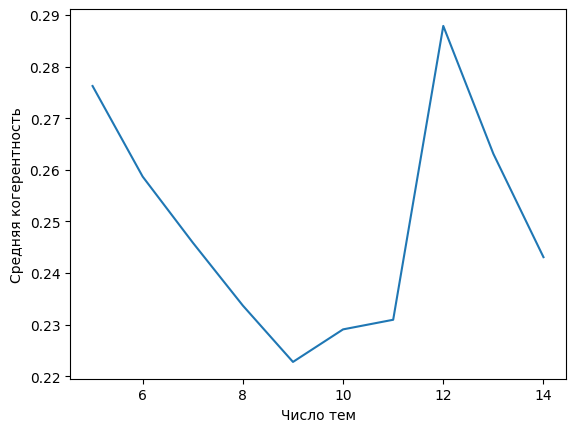

In [35]:
plt.plot(topics_list, coherences)
plt.xlabel("Число тем")
plt.ylabel("Средняя когерентность")
plt.show()